In [1]:
# !pip install scikit-learn
# !pip install pathlib
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas

In [24]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pandas as pd
from pathlib import Path
import os
import random


In [25]:
#TASK 1.1 IMDB DATA PROCESSING
np.random.seed(1234)
#loading data
data_path = Path(os.getcwd()) / 'C:\\Users\\David\\aclImdb_v1.real\\aclImdb'

train_path = data_path/'train'
test_path = data_path/'test'

In [26]:
#TASK 1.1 IMDB DATA PROCESSING
# Splitting data
def read_data(dir_path):
    """read data into pandas dataframe"""
    def load_dir_reviews(reviews_path):
        files_list = list(reviews_path.iterdir())
        reviews = []
        for filename in files_list:
            f = open(filename, 'r', encoding='utf-8')
            reviews.append(f.read())
        return pd.DataFrame({'text':reviews})
    pos_path = dir_path/'pos'
    neg_path = dir_path/'neg'
    pos_reviews, neg_reviews = load_dir_reviews(pos_path), load_dir_reviews(neg_path)
    pos_reviews['label'] = 1
    neg_reviews['label'] = 0
    merged = pd.concat([pos_reviews, neg_reviews])
    merged.reset_index(inplace=True)
    return merged

train = read_data(train_path)
test = read_data(test_path)

imdb_X_train, imdb_y_train = train['text'], train['label'] # split the dataset to data and label
imdb_X_test, imdb_y_test = test['text'], test['label'] # split the dataset to data and label

In [27]:
#TASK 1.1 IMDB DATA PROCESSING
# Convert the text data into numerical feature vector (excluding rare and stopwords)
CV = CountVectorizer(min_df=0.01,max_df=0.50)
IMDB_X_train_cv = CV.fit_transform(imdb_X_train)
IMDB_X_test_cv = CV.transform(imdb_X_test)
print(IMDB_X_train_cv.shape)

(25000, 1780)


In [28]:
#TASK 1.1 IMDB DATA PROCESSING
# Convert CountVectorizer to frequency using tf–idf  
IMBD_tfidf_transformer = TfidfTransformer(use_idf=True)
# create tfidf matrix
IMDB_X_train_tfidf = IMBD_tfidf_transformer.fit_transform(IMDB_X_train_cv)
IMDB_X_test_tfidf = IMBD_tfidf_transformer.transform(IMDB_X_test_cv)

IMDB_train_x_pd = pd.DataFrame.sparse.from_spmatrix(IMDB_X_train_tfidf)
IMDB_test_x_pd = pd.DataFrame.sparse.from_spmatrix(IMDB_X_test_tfidf)

In [29]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
    
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        #alternatively: self.w = np.linalg.inv(x.T @ x)@x.T@y
        self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh

#running linear regression with IMBD data
N = 25000
lin_x = IMDB_train_x_pd
lin_y = imdb_y_train
model = LinearRegression()
lin_yh = model.fit(lin_x,lin_y).predict(lin_x)

#print(model.w)
w_list = abs(model.w)
w_list = w_list.tolist()
sorted_w_list = sorted(w_list)
print(len(sorted_w_list))

max_400w=[]
for i in range(400):
    ma = w_list.index(sorted_w_list[1280+i])
    max_400w.append(ma)


max_400features = []
for i in max_400w:
    max_400features.append(CV.get_feature_names_out()[i])

# print("the top 400 features with the most positive coefficients are features" , max_400features)

C:\Users\David\AppData\Local\Temp\ipykernel_22948\1994663271.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference


1781


In [30]:
#TASK 1.1 IMDB DATA PROCESSING
# Standardize the features and target labels
from sklearn.preprocessing import StandardScaler
imdb_x_train_norm = StandardScaler().fit_transform(IMDB_train_x_pd.to_numpy())
imdb_y_train_norm = StandardScaler().fit_transform(np.reshape(imdb_y_train, (-1,1))).flatten()

imdb_x_train_transposed = np.transpose(imdb_x_train_norm)

In [31]:
#TASK 1.1 IMDB DATA PROCESSING - FEATURE SELECTION
imdb_top_feature_index = max_400w
imdb_x_train_top400 = IMDB_train_x_pd.iloc[:, imdb_top_feature_index]

# Select top 400 features for test set
imdb_x_test_features = IMDB_test_x_pd.iloc[:, imdb_top_feature_index]
#print(imdb_x_test_features.shape)

# Standardize features
imdb_x_train_top400_norm = StandardScaler().fit_transform(imdb_x_train_top400.to_numpy())
imdb_x_test_top400_norm = StandardScaler().fit_transform(imdb_x_test_features.to_numpy())
# print(imdb_x_train_top400_norm)
# print(type(imdb_top_zscore_index))

In [32]:
#TASK 1.2 20 NEWS GROUPS DATA PROCCESSING
#chooses 5 of the 20 categories
categories = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball','sci.med', 'talk.politics.guns'] 
print()
news_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers', 'quotes'), shuffle=True,random_state=42)
# news_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers', 'quotes'), shuffle=True,random_state=42)

news_test = fetch_20newsgroups(subset='test',categories=categories, remove=('headers','footers', 'quotes'),shuffle=True,random_state=42)

In [33]:
from sklearn.metrics import mutual_info_score
from heapq import heappush, heappushpop

cv = CountVectorizer()
X_train_counts = cv.fit_transform(news_train.data)

y_news_train = np.zeros((news_train.target.size, 5))
len_news_train_indices = np.arange(news_train.target.size)
y_news_train[len_news_train_indices, news_train.target] = 1


clean = ((X_train_counts != 0).sum(0))/y_news_train.shape[0]
valid_news_indices = np.where((clean < .01) | (clean > 0.5), False, True).flatten()
valid_news_indices = np.array(valid_news_indices, dtype=bool)

X_news = X_train_counts[:, valid_news_indices]
best_features_news = set()

for i in range(5):
    minheap = []
    for j in range(X_news.shape[1]):
        mis = mutual_info_score(y_news_train[:,i], X_news[:,j].toarray().flatten())
        if len(minheap) < 100:
            heappush(minheap, (mis,j))
        elif minheap[0][0] < mis:
            heappushpop(minheap, (mis,j))
  
    new_words = set([i for (_,i) in minheap])
    best_features_news.update(new_words)

list_best_features = list(best_features_news)    
X_news_train = X_news[:, list(best_features_news)]

In [34]:
#TASK 1.2 20 NEWS GROUPS DATA PROCCESSING
from sklearn import model_selection
X_news_train_, X_news_valid, y_news_train_, y_news_valid = model_selection.train_test_split(X_news_train, y_news_train, test_size = 0.5, random_state=1, shuffle=True)
X_news_train_scaled = np.array(StandardScaler().fit_transform(X_news_train_.toarray()), dtype=np.longdouble)
X_news_valid_scaled = StandardScaler().fit_transform(X_news_valid.toarray())

print(X_news_train_scaled.shape)
print(y_news_train_.shape) 
print(X_news_valid_scaled.shape) 
print(y_news_valid.shape)

(1453, 362)
(1453, 5)
(1453, 362)
(1453, 5)


In [35]:
#TASK 2 LOGISTIC REGRESSION - DEFINING LOGISTIC FUNCTION
logistic = lambda z: 1./ (1 + np.exp(-z))

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad

    def cost_fn(self, x, y, w):
        N, D = x.shape                                                       
        z = np.dot(x, w)
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
        return J

    def check_grad(self,x,y):
    
        N, D = x.shape
        diff = np.zeros(D)
        w = self.w.copy()

        for i in range(D):
            epsilon = np.zeros((D))
            epsilon[i] = np.random.rand() * 1e-4

            self.w = self.w + epsilon
            J1 = self.cost_fn(x, y, self.w)
            self.w = w

            self.w = self.w - epsilon
            J2 = self.cost_fn(x, y, self.w)
            self.w = w

            numeric_grad = (J1 - J2) / (2 * epsilon[i])
            derived_grad = self.gradient(x, y)[i]

            diff[i] = np.square(derived_grad - numeric_grad).sum() / \
                         np.square(derived_grad + numeric_grad).sum()
        return diff.sum()

    def monitor(self, x, y):
        cost_all = np.zeros(int(self.max_iters))
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            cost_all[t] = self.cost_fn(x,y,self.w)
            t += 1
        return cost_all, self

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, self.w
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

def evaluate_acc(y_pred, y_test):
    accuracy = np.sum(y_pred == y_test)/y_test.shape[0]

In [36]:
#TASK 2 MULTICLASS REGRESSION

import math
class MulticlassRegression:
    def __init__(self, num_features, num_classes, learning_rate=.0005, epsilon=1e-4, max_iters=1e3):
        
        #populate W with values from a random sample from a uniform distribution
        self.lr = learning_rate
        self.epsilon = epsilon
        self.max_iters = math.floor(max_iters)
        self.num_features = num_features
        self.num_classes = num_classes
        self.W = np.array(np.random.rand(num_features, num_classes), dtype=np.longdouble)
      
    def predict(self, x):
        #compute product XW
        z = x @ self.W
        #compute soft max
        #adjust terms 
        z_max = z.max(axis=1)
        z = z - np.tile(z_max, (5, 1)).transpose()
        y_pred = np.exp(z)
        return y_pred / y_pred.sum(axis=1).reshape(x.shape[0], 1)

    def gradient(self, x, y):
        x_t = np.transpose(x)
        return x_t @ (self.predict(x) - y) 

    def cost(self, x, y):
        return -np.nansum(y * np.log(self.predict(x)))

    def fit(self, x, y, x_valid=None, y_valid=None):
        loss_train = np.array([])
        loss_valid = np.array([])
        for n in range(self.max_iters):
            
            g = self.gradient(x, y)
            self.W = self.W - self.lr * g
            cost = self.cost(x,y)
            loss_train = np.append(loss_train, cost)
            if x_valid is not None and y_valid is not None:
                loss_valid = np.append(loss_valid, self.cost(x_valid, y_valid))
            if np.linalg.norm(g) < self.epsilon:
                break
    
        return loss_train, loss_valid
  
    def check_grad(self, x, y):
        N, C = y.shape
        D = x.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.cost(x, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.cost(x, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.gradient(x, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                          np.square(derived_grad + numeric_grad).sum()


        return diff.sum()

In [37]:
#TASK 3.1 - 10 TOP FEATURES
#defining simple linear regression

lin_train = read_data(train_path)

lin_imdb_X_train, lin_imdb_y_train = lin_train['text'], lin_train['label'] # split the dataset to data and label

# Convert the text data into numerical feature vector (excluding rare and stopwords)
lin_IMDB_X_train_cv = CV.fit_transform(lin_imdb_X_train)

#frequency
# create tfidf matrix
lin_IMDB_X_train_tfidf = IMBD_tfidf_transformer.fit_transform(lin_IMDB_X_train_cv)

lin_IMDB_train_x_pd = pd.DataFrame.sparse.from_spmatrix(lin_IMDB_X_train_tfidf)

In [38]:
#running linear regression with IMBD data
N = 25000
lin_x = lin_IMDB_train_x_pd
lin_y = lin_imdb_y_train
model = LinearRegression()
lin_yh = model.fit(lin_x,lin_y).predict(lin_x)

#print(model.w)
w_list = model.w
w_list = w_list.tolist()
sorted_w_list = sorted(w_list)
# print(len(sorted_w_list))

min_w=[]
max_w=[]

for i in range(10):
    total = len(w_list)
    mi = w_list.index(sorted_w_list[i])
    min_w.append(mi)

for i in range(10):
    ma = w_list.index(sorted_w_list[1780-i])
    max_w.append(ma)

print(len(max_w))
min_features = []
for i in min_w:
    min_features.append(CV.get_feature_names_out()[i])


max_features = []
for i in max_w:
    max_features.append(CV.get_feature_names_out()[i])

# print(CV.get_feature_names_out()[2])
print("the 10 features with the most negative coefficients are features" , min_features)
print("the 10 features with the most positive coefficients are features" , max_features)

C:\Users\David\AppData\Local\Temp\ipykernel_22948\1994663271.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference


10
the 10 features with the most negative coefficients are features ['worst', 'disappointment', 'disappointing', 'lacks', 'fails', 'unfortunately', 'poorly', 'dull', 'annoying', 'poor']
the 10 features with the most positive coefficients are features ['excellent', 'great', 'wonderfully', 'perfect', 'rare', 'noir', 'enjoyable', 'today', 'funniest', 'favorite']


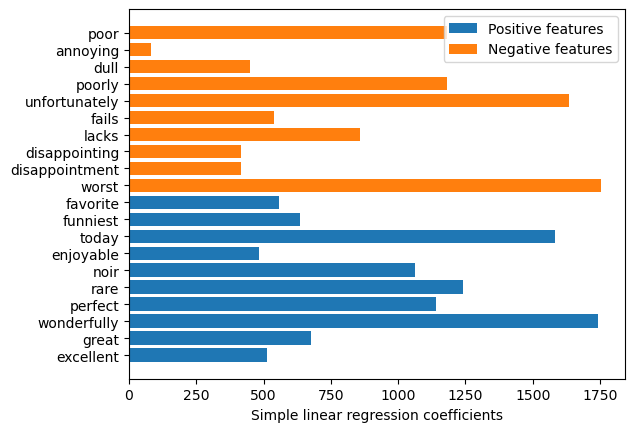

In [39]:
plt.barh(max_features, max_w, label="Positive features")
plt.barh(min_features, min_w, label="Negative features")
plt.xlabel("Simple linear regression coefficients")
plt.legend()

In [40]:
#CREATIVITY: FINDING BEST LEARNING RATE AND MAX ITERATIONS FOR LOGISTIC REGRESSION ON IMBD DATA
test_accuracies=[]
for rate in range(10):
    for it in range(10):
        var_logitreg = LogisticRegression(learning_rate = rate*0.01+0.01, max_iters=it*100+100)
        var_fit, var_w = var_logitreg.fit(imdb_x_train_top400_norm, imdb_y_train)
        var_pred_train = var_fit.predict(imdb_x_train_top400_norm)
        var_pred_train_bi = (var_pred_train > 0.5).astype(int)
        var_pred_test = var_fit.predict(imdb_x_test_top400_norm)
        var_pred_test_bi = (var_pred_test > 0.5).astype(int)
        
        var_acc_train = sum(var_pred_train_bi==imdb_y_train)/len(imdb_y_train)
        var_acc_test = sum(var_pred_test_bi==imdb_y_test)/len(imdb_y_test)
        test_accuracies.append(var_acc_test)
        print("with learning rate = ", rate*0.01+0.01 , " and maximum iterations = " , it*100+100 , "training accuracy = " , var_acc_train , "and test accuracy = " , var_acc_test)

with learning rate =  0.01  and maximum iterations =  100 training accuracy =  0.80848 and test accuracy =  0.78736
with learning rate =  0.01  and maximum iterations =  200 training accuracy =  0.81036 and test accuracy =  0.78764
with learning rate =  0.01  and maximum iterations =  300 training accuracy =  0.8106 and test accuracy =  0.78872
with learning rate =  0.01  and maximum iterations =  400 training accuracy =  0.81148 and test accuracy =  0.7896
with learning rate =  0.01  and maximum iterations =  500 training accuracy =  0.8124 and test accuracy =  0.78964
with learning rate =  0.01  and maximum iterations =  600 training accuracy =  0.81344 and test accuracy =  0.7892
with learning rate =  0.01  and maximum iterations =  700 training accuracy =  0.81332 and test accuracy =  0.78856
with learning rate =  0.01  and maximum iterations =  800 training accuracy =  0.81332 and test accuracy =  0.7888
with learning rate =  0.01  and maximum iterations =  900 training accuracy =

In [41]:
#CREATIVITY: FINDING BEST LEARNING RATE AND MAX ITERATIONS FOR LOGISTIC REGRESSION ON IMBD DATA ABS
print(test_accuracies)
max_ind = test_accuracies.index(max(test_accuracies))
print(max_ind)
print(test_accuracies[max_ind])

print("The highest test accuracy of " , test_accuracies[max_ind] , " is achieved with a learning rate of 0.01 and the maximum number of iterations set to 500")

[0.78736, 0.78764, 0.78872, 0.7896, 0.78964, 0.7892, 0.78856, 0.7888, 0.78916, 0.78896, 0.78764, 0.78952, 0.78916, 0.7888, 0.78896, 0.7888, 0.78856, 0.78848, 0.78876, 0.7888, 0.78864, 0.78916, 0.78912, 0.7888, 0.78864, 0.78876, 0.78872, 0.78864, 0.78872, 0.7888, 0.78952, 0.78884, 0.78876, 0.78848, 0.7888, 0.78864, 0.7888, 0.78856, 0.7888, 0.7884, 0.78964, 0.78896, 0.78864, 0.78888, 0.78868, 0.7888, 0.78864, 0.7884, 0.78856, 0.7884, 0.78916, 0.78876, 0.7888, 0.78864, 0.78884, 0.7888, 0.78844, 0.78856, 0.78828, 0.78812, 0.78852, 0.78856, 0.78868, 0.7888, 0.78864, 0.78844, 0.78848, 0.78828, 0.78804, 0.78796, 0.78884, 0.78852, 0.78864, 0.7886, 0.7884, 0.78856, 0.78828, 0.78804, 0.78796, 0.78788, 0.7892, 0.7888, 0.78864, 0.7888, 0.78856, 0.78828, 0.78804, 0.78796, 0.78792, 0.78796, 0.78904, 0.78888, 0.78884, 0.7884, 0.7884, 0.78812, 0.78796, 0.78792, 0.78796, 0.78804]
4
0.78964
The highest test accuracy of  0.78964  is achieved with a learning rate of 0.01 and the maximum number of iteratio

In [42]:
#TASK 3.2.a IMPLIMENTING LOGISTIC REGRESSION ON IMBD DATA
# Use top 400 featuers
logitreg = LogisticRegression(learning_rate = 0.05, max_iters=500)
fit, w = logitreg.fit(imdb_x_train_top400_norm, imdb_y_train)

pred_train = fit.predict(imdb_x_train_top400_norm)
pred_train_bi = (pred_train > 0.5).astype(int)
pred_test = fit.predict(imdb_x_test_top400_norm)
pred_test_bi = (pred_test > 0.5).astype(int)

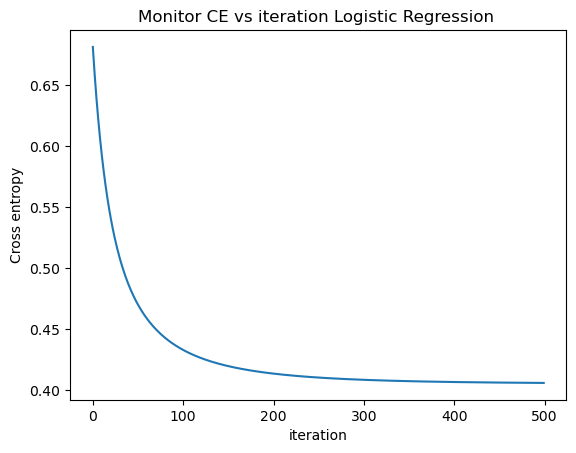

In [43]:
#TASK 2.1 LOGISTIC REGRESSION - MONITERING CROSS ENTROPY USING SMALL PERTURBATION
logitreg = LogisticRegression(learning_rate = 0.05, max_iters=500)
loss = logitreg.monitor(imdb_x_train_top400_norm, np.array(imdb_y_train))[0]
fit = logitreg.monitor(imdb_x_train_top400_norm, np.array(imdb_y_train))[1]
#print(fit.check_grad(imdb_x_train_top500_norm, np.array(imdb_y_train)))

plt.clf()
plt.plot(loss)
plt.title('Monitor CE vs iteration Logistic Regression ')
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
plt.show()

In [44]:
#TASK 3.2.b IMPLIMENTING MULTICLASS REGRESSION ON 20 NEWS GROUP DATA
model = MulticlassRegression(X_news_train.shape[1], y_news_train.shape[1])

In [45]:
#TASK 3.2.b IMPLIMENTING MULTICLASS REGRESSION ON 20 NEWS GROUP DATA
model.check_grad(X_news_train, y_news_train)
print(X_news_train.shape)
print(y_news_train.shape)

(2906, 362)
(2906, 5)


In [46]:
m = MulticlassRegression(X_news_train.shape[1], y_news_train.shape[1])


X_news_train_, X_news_valid, y_news_train_, y_news_valid = model_selection.train_test_split(X_news_train, y_news_train, test_size = 0.5, random_state=1, shuffle=True)
X_news_train_scaled = np.array(StandardScaler().fit_transform(X_news_train_.toarray()), dtype=np.longdouble)
X_news_valid_scaled = StandardScaler().fit_transform(X_news_valid.toarray())

print(X_news_train_scaled.shape)
print(y_news_train_.shape) 
print(X_news_valid_scaled.shape) 
print(y_news_valid.shape)

ce_train, ce_valid = m.fit(X_news_train_scaled, y_news_train_, X_news_valid_scaled, y_news_valid)
optimal_news_iter = ce_valid.argmin()
print(optimal_news_iter)

#Using optimal iter
model = MulticlassRegression(X_news_train.shape[1], y_news_train.shape[1], max_iters=optimal_news_iter)
X_news_train_scaled = np.array(StandardScaler().fit_transform(X_news_train.toarray()), dtype=np.longdouble)
ce_train, ce_valid = model.fit(X_news_train_scaled, y_news_train)


(1453, 362)
(1453, 5)
(1453, 362)
(1453, 5)


C:\Users\David\AppData\Local\Temp\ipykernel_22948\2811542086.py:30: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(y * np.log(self.predict(x)))
C:\Users\David\AppData\Local\Temp\ipykernel_22948\2811542086.py:30: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(y * np.log(self.predict(x)))


192


C:\Users\David\AppData\Local\Temp\ipykernel_22948\2811542086.py:30: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(y * np.log(self.predict(x)))
C:\Users\David\AppData\Local\Temp\ipykernel_22948\2811542086.py:30: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(y * np.log(self.predict(x)))


Text(0.5, 1.0, 'Cross entropy vs Iteration: Multiclass Regression model on 20-news-group dataset ')

<Figure size 640x480 with 0 Axes>

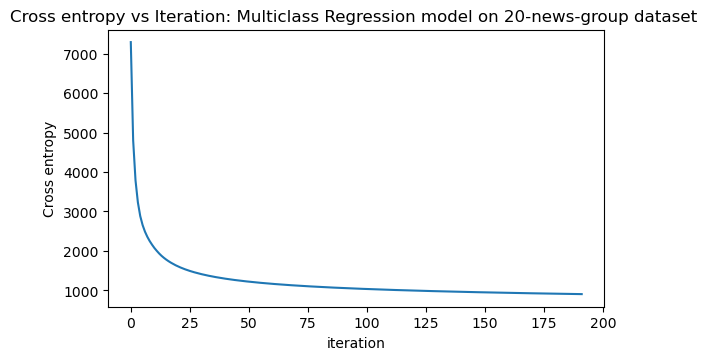

In [47]:
#TASK 2.1 MULTICLASS REGRESSION - MONITERING CROSS ENTROPY USING SMALL PERTURBATION

plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.plot(ce_train)
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
plt.title("Cross entropy vs Iteration: Multiclass Regression model on 20-news-group dataset ")

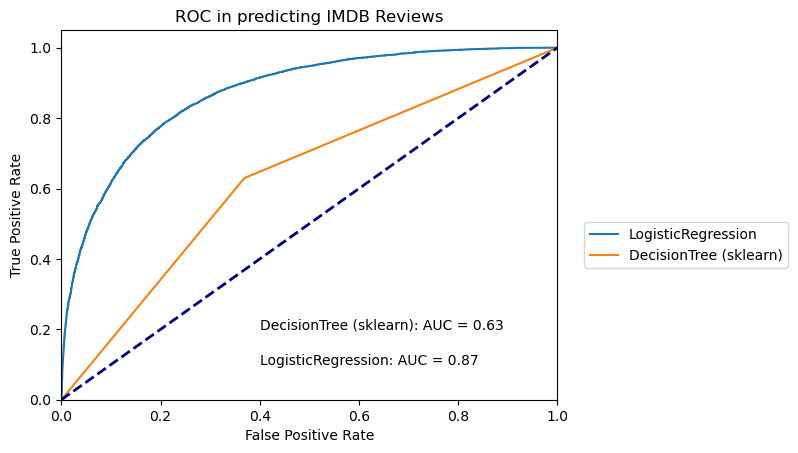

In [48]:
#TASK 3.3 LOGISTIC REGRESSION - PLOTTING ROC FOR LOG REGRESSION VS DT
perf = {}

fpr_log, tpr_log, _ = roc_curve(imdb_y_test, pred_test)
auroc_log = roc_auc_score(imdb_y_test, pred_test)
perf["LogisticRegression"] = {'fpr':fpr_log, 'tpr':tpr_log, 'auroc':auroc_log}

# DT
fit_dt = DecisionTreeClassifier().fit(imdb_x_train_top400_norm,imdb_y_train)
y_test_prob_dt = fit_dt.predict_proba(imdb_x_test_top400_norm)[:,1]
fpr_dt, tpr_dt, _ = roc_curve(imdb_y_test, y_test_prob_dt)
auroc_dt = roc_auc_score(imdb_y_test, y_test_prob_dt)
perf["DecisionTree (sklearn)"] = {'fpr':fpr_dt,'tpr':tpr_dt,'auroc':auroc_dt}

plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB Reviews')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")

In [49]:
#TASK 3.4 multiclass linear regression and Decision
# Trees on the 5 chosen classes
# train/test acc
news_test = fetch_20newsgroups(subset="test", categories=categories, remove=('headers', 'footers', 'quotes'))
cv_test = CountVectorizer()
X_test_counts = cv_test.fit_transform(news_test.data)
test_words = cv_test.vocabulary_
valid_news_words = cv.get_feature_names_out()[valid_news_indices]
feature_names = valid_news_words[list_best_features]
X_news_test = np.zeros((X_test_counts.shape[0], X_news_train.shape[1]))
for i in range(feature_names.shape[0]):
    if feature_names[i] in test_words:
        X_news_test[:,i] = X_test_counts[:,test_words[feature_names[i]]].toarray().flatten()

y_test_news = np.zeros((news_test.target.size, 5))
y_test_news[np.arange(news_test.target.size), news_test.target] = 1
y_news_pred = model.predict(X_news_test)

acc = sum(y_news_pred.argmax(axis=1) == y_test_news.argmax(axis=1))
acc = acc / y_test_news.shape[0]
print("Accuracy of Multiclass Regression:", acc)

dt = DecisionTreeClassifier(criterion = 'gini', min_samples_split=92, splitter='random', min_samples_leaf=1)
pred_test_dt = dt.fit(X_news_train, y_news_train)
acc_train_dt = pred_test_dt.score(X_news_test, y_test_news)
print("Accuracy of Decision Tree:", acc_train_dt)


Accuracy of Multiclass Regression: 0.6942148760330579
Accuracy of Decision Tree: 0.5831611570247934


In [50]:
#TASK 3.5 MULTICLASS REGRESSION - CLASSIFICATION ACCURACY

In [51]:
# Splitting training data into percentages 

def split_train(x_train, y_train, x_test, y_test, split_rate):
    x_none, x_train, y_none, y_train = model_selection.train_test_split(x_train, y_train, test_size = split_rate, random_state=1, shuffle=True)
    
    # logistic
    fit,w = LogisticRegression(learning_rate = 0.05, max_iters=500).fit(x_train, y_train)
    pred_test_lo = (fit.predict(x_test) > 0.5).astype(int)
    auroc_lo = round(roc_auc_score(y_test, pred_test_lo),3)

    # DT
    dt = DecisionTreeClassifier(criterion = 'gini', min_samples_split=92, splitter='random', min_samples_leaf=1)
    pred_test_dt = dt.fit(x_train, y_train).predict(x_test)
    auroc_dt = round(roc_auc_score(y_test, pred_test_dt),3)

    return auroc_lo, auroc_dt

In [52]:
auroc_log_train20,auroc_dt_train20 = split_train(imdb_x_train_top400_norm,imdb_y_train,imdb_x_test_top400_norm,imdb_y_test,0.2)
print(auroc_log_train20)

0.776


In [53]:
dt_imdb = DecisionTreeClassifier(criterion = 'gini', min_samples_split=92, splitter='random', min_samples_leaf=1)
dt_imdb.fit(imdb_x_train_top400_norm,imdb_y_train)
pred = dt_imdb.predict(imdb_x_test_top400_norm)
imdb_auroc_dt = roc_auc_score(imdb_y_test, pred)
fpr_dt, dt_knn, _ = roc_curve(imdb_y_test, pred)
print("Auroc of Decision Tree:",imdb_auroc_dt)

fit,w = LogisticRegression(learning_rate = 0.05, max_iters=500).fit(imdb_x_train_top400_norm, imdb_y_train)
pred_test_log = (fit.predict(imdb_x_test_top400_norm) > 0.5).astype(int)
auroc_log = round(roc_auc_score(imdb_y_test, pred_test_log),3)

print("Auroc of Logistic Regression:",auroc_log)

Auroc of Decision Tree: 0.64804
Auroc of Logistic Regression: 0.789


random 0.2: LogisticR auroc 0.776, DT auroc 0.622
random 0.4: LogisticR auroc 0.784, DT auroc 0.629
random 0.6: LogisticR auroc 0.786, DT auroc 0.639
random 0.8: LogisticR auroc 0.786, DT auroc 0.642


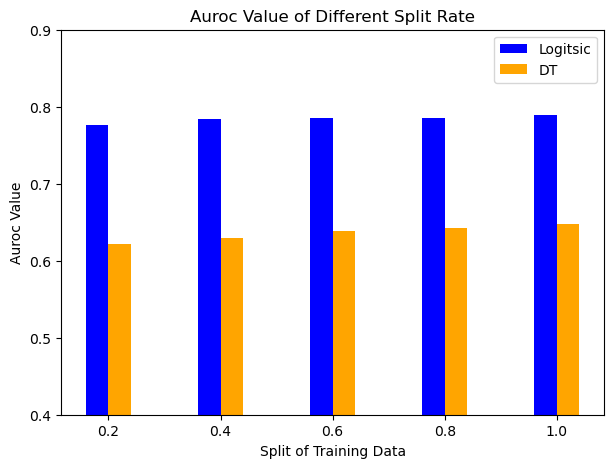

In [54]:
#TASK 3.5 LOGISTIC REGRESSION IMDB- TRAINING DATASET SPLITTING
split = [0.2, 0.4, 0.6, 0.8]
all_split = [0.2, 0.4, 0.6, 0.8,1.0]
auroc_log_all = []
auroc_dt_all = []

i = 0
while i < len(split):
    res = split_train(imdb_x_train_top400_norm,imdb_y_train,imdb_x_test_top400_norm,imdb_y_test,split[i])
    auroc_log_all.append(res[0])
    auroc_dt_all.append(res[1])  
    print(f"random {split[i]}: LogisticR auroc {res[0]}, DT auroc {res[1]}")
    i += 1

auroc_dt_all.append(round(imdb_auroc_dt,3))
auroc_log_all.append(auroc_log)
    
    
fig = plt.figure(figsize = (7, 5))
x = np.arange(len(all_split))

plt.ylim([0.4,0.9])
plt.bar(x-0.1, auroc_log_all, color ='blue', width = 0.2)
plt.bar(x+0.1, auroc_dt_all, color = 'orange', width = 0.2)
plt.xticks(x, all_split)
plt.xlabel("Split of Training Data")
plt.ylabel("Auroc Value")
plt.title("Auroc Value of Different Split Rate")
plt.legend(["Logitsic", "DT"])
plt.show()

Accuracy of multiclass 0.6513429752066116
Accuracy of DT 0.5692148760330579
Accuracy of multiclass 0.7319214876033058
Accuracy of DT 0.5428719008264463


C:\Users\David\AppData\Local\Temp\ipykernel_22948\2811542086.py:30: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(y * np.log(self.predict(x)))
C:\Users\David\AppData\Local\Temp\ipykernel_22948\2811542086.py:30: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(y * np.log(self.predict(x)))
C:\Users\David\AppData\Local\Temp\ipykernel_22948\2811542086.py:30: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(y * np.log(self.predict(x)))
C:\Users\David\AppData\Local\Temp\ipykernel_22948\2811542086.py:30: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(y * np.log(self.predict(x)))


Accuracy of multiclass 0.7401859504132231
Accuracy of DT 0.5511363636363636
Accuracy of multiclass 0.7598140495867769
Accuracy of DT 0.5521694214876033


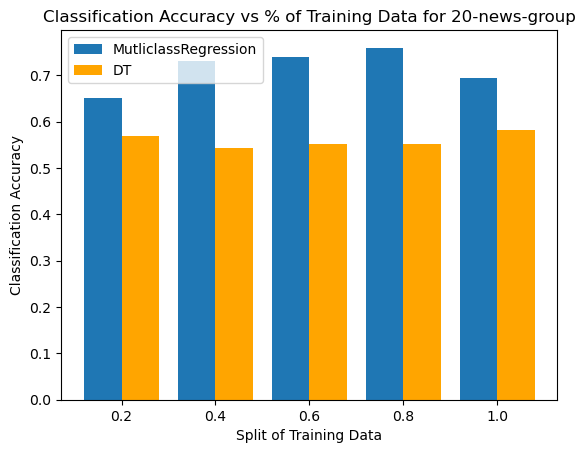

In [55]:
dt_acc_values = []
multireg_acc_values = []
all_split = [0.2,0.4,0.6,0.8,1.0]
for i in [.2,.4,.6,.8]:
    news_train_x, _, news_train_y, _ = model_selection.train_test_split(X_news_train, y_news_train, test_size=1-i, random_state=1, shuffle=True)

    multireg = MulticlassRegression(news_train_x.shape[1], news_train_y.shape[1], max_iters=optimal_news_iter)
    multireg.fit(news_train_x, news_train_y)
    multireg_pred = multireg.predict(X_news_test)
    multireg_acc = sum(multireg_pred.argmax(axis=1) == y_test_news.argmax(axis=1)) / y_test_news.shape[0]
    multireg_acc_values.append(multireg_acc)
    
    dt = DecisionTreeClassifier(criterion = 'gini', min_samples_split=92, splitter='random', min_samples_leaf=1)
    pred_test_dt = dt.fit(X_news_train, y_news_train)
    acc_test_dt = pred_test_dt.score(X_news_test, y_test_news)
    dt_acc_values.append(acc_test_dt)
    print("Accuracy of multiclass",multireg_acc)
    print("Accuracy of DT",acc_test_dt)
    
dt_acc_values.append(acc_train_dt)
multireg_acc_values.append(acc)
X_axis = np.arange(len(all_split))

plt.bar(X_axis - 0.2, multireg_acc_values, 0.4, label = 'MutliclassRegression')
plt.bar(X_axis + 0.2, dt_acc_values, 0.4,color = 'orange',label = 'DT')
  
plt.xticks(X_axis, all_split)
plt.xlabel("Split of Training Data")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy vs % of Training Data for 20-news-group")
plt.legend()
plt.show()
     

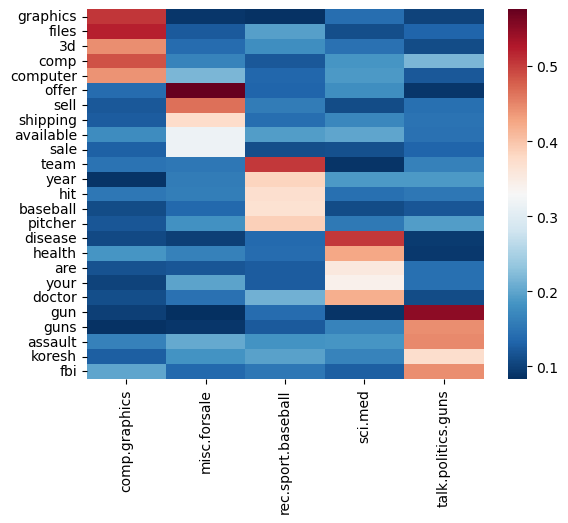

In [56]:
best_feature_indicies = np.array(np.zeros((5,5)),dtype=int)
for i in range(5):
    best_feature_indicies[i,:] = np.argsort(model.W[:,i], axis=0)[::-1][:5]
best_feature_names = feature_names[best_feature_indicies]
W_hat = model.W[best_feature_indicies]
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=0)[None,:]

W_hat_transformed_df = pd.DataFrame(W_hat_transformed.reshape(25,5), columns=news_train.target_names, index=best_feature_names.flatten())
from seaborn import heatmap
hmp = heatmap(W_hat_transformed_df, cmap='RdBu_r')
fig = hmp.get_figure()

10
the 10 features with the most negative coefficients are features ['bad', 'worst', 'no', 'just', 'even', 'waste', 'awful', 'they', 'nothing', 'terrible']
the 10 features with the most positive coefficients are features ['great', 'his', 'best', 'love', 'very', 'excellent', 'well', 'wonderful', 'also', 'life']


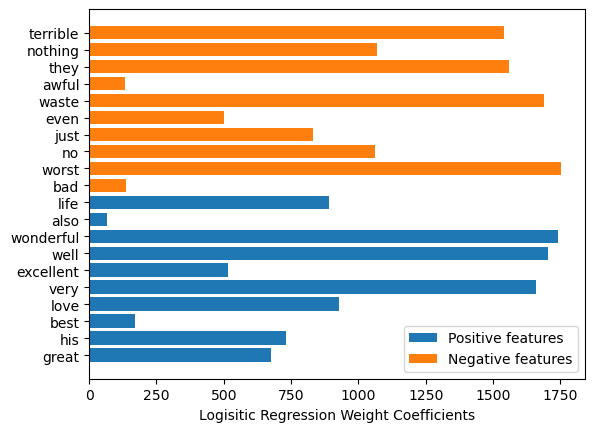

In [57]:
#running linear regression with IMBD data
N = 25000
model = LogisticRegression(learning_rate = 0.05, max_iters=500)


fit, w = model.fit(IMDB_train_x_pd, imdb_y_train)

pred_train = fit.predict(IMDB_train_x_pd)
pred_train_bi = (pred_train > 0.5).astype(int)
pred_test = fit.predict(IMDB_test_x_pd)
pred_test_bi = (pred_test > 0.5).astype(int)


#print(model.w)
w_list = model.w

w_list = w_list.tolist()
sorted_w_list = sorted(w_list)
# print(len(sorted_w_list))

min_w=[]
max_w=[]

for i in range(10):
    total = len(w_list)
    mi = w_list.index(sorted_w_list[i])
    min_w.append(mi)

for i in range(10):
    ma = w_list.index(sorted_w_list[1780-i])
    max_w.append(ma)

print(len(max_w))
min_features = []
for i in min_w:
    min_features.append(CV.get_feature_names_out()[i])


max_features = []
for i in max_w:
    max_features.append(CV.get_feature_names_out()[i])

# print(CV.get_feature_names_out()[2])
print("the 10 features with the most negative coefficients are features" , min_features)
print("the 10 features with the most positive coefficients are features" , max_features)

plt.barh(max_features, max_w, label="Positive features")
plt.barh(min_features, min_w, label="Negative features")
plt.xlabel('Logisitic Regression Weight Coefficients')
plt.legend()

C:\Users\David\AppData\Local\Temp\ipykernel_22948\2811542086.py:30: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(y * np.log(self.predict(x)))
C:\Users\David\AppData\Local\Temp\ipykernel_22948\2811542086.py:30: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(y * np.log(self.predict(x)))


[0.7401859504132231]
[0.7401859504132231, 0.7334710743801653]
[0.7401859504132231, 0.7334710743801653, 0.7422520661157025]
[0.7401859504132231, 0.7334710743801653, 0.7422520661157025, 0.731404958677686]


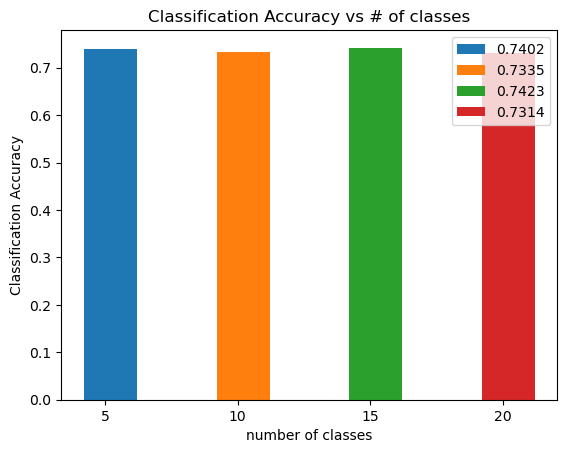

In [67]:
#TASK 1.2 20 NEWS GROUPS DATA PROCCESSING
#chooses 5 of the 20 categories
from sklearn import model_selection
np.random.seed(1234)
multireg_acc_ = []
categories = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball','sci.med', 'talk.politics.guns'] 
print()
news_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers', 'quotes'), shuffle=True,random_state=42)
news_test = fetch_20newsgroups(subset='test',categories=categories, remove=('headers','footers', 'quotes'),shuffle=True,random_state=42)
news_train_x, _, news_train_y, _ = model_selection.train_test_split(X_news_train, y_news_train, test_size=0.4, random_state=1, shuffle=True)
# X_news_train_scaled = np.array(StandardScaler().fit_transform(X_news_train_.toarray()), dtype=np.longdouble)

multireg = MulticlassRegression(news_train_x.shape[1], news_train_y.shape[1], max_iters=optimal_news_iter)
multireg.fit(news_train_x, news_train_y)
multireg_pred = multireg.predict(X_news_test)
multireg_acc = sum(multireg_pred.argmax(axis=1) == y_test_news.argmax(axis=1)) / y_test_news.shape[0]
multireg_acc_.append(multireg_acc)

    
print(multireg_acc_)
# # multireg_acc.append(acc)
# X_axis = np.arange(len(all_split))

# ###########

categories = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball','sci.med', 'talk.politics.guns', 'comp.sys.ibm.pc.hardware' , 'sci.space' , 'sci.crypt', 'talk.politics.mideast', 'soc.religion.christian' ] 
news_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers', 'quotes'), shuffle=True,random_state=42)
news_test = fetch_20newsgroups(subset='test',categories=categories, remove=('headers','footers', 'quotes'),shuffle=True,random_state=42)
news_train_x, _, news_train_y, _ = model_selection.train_test_split(X_news_train, y_news_train, test_size=0.4, random_state=1, shuffle=True)
# X_news_train_scaled = np.array(StandardScaler().fit_transform(X_news_train_.toarray()), dtype=np.longdouble)

multireg = MulticlassRegression(news_train_x.shape[1], news_train_y.shape[1], max_iters=optimal_news_iter)
multireg.fit(news_train_x, news_train_y)
multireg_pred = multireg.predict(X_news_test)
multireg_acc = sum(multireg_pred.argmax(axis=1) == y_test_news.argmax(axis=1)) / y_test_news.shape[0]
multireg_acc_.append(multireg_acc)

    
print(multireg_acc_)


# ###########

categories = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball','sci.med', 'talk.politics.guns', 'comp.sys.ibm.pc.hardware' , 'sci.space' , 'sci.crypt', 'talk.politics.mideast', 'soc.religion.christian', 'talk.politics.misc', 'talk.religion.misc', 'sci.electronics' ,'rec.sport.hockey','rec.motorcycles' ] 
news_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers', 'quotes'), shuffle=True,random_state=42)
news_test = fetch_20newsgroups(subset='test',categories=categories, remove=('headers','footers', 'quotes'),shuffle=True,random_state=42)
news_train_x, _, news_train_y, _ = model_selection.train_test_split(X_news_train, y_news_train, test_size=0.4, random_state=1, shuffle=True)
# X_news_train_scaled = np.array(StandardScaler().fit_transform(X_news_train_.toarray()), dtype=np.longdouble)

multireg = MulticlassRegression(news_train_x.shape[1], news_train_y.shape[1], max_iters=optimal_news_iter)
multireg.fit(news_train_x, news_train_y)
multireg_pred = multireg.predict(X_news_test)
multireg_acc = sum(multireg_pred.argmax(axis=1) == y_test_news.argmax(axis=1)) / y_test_news.shape[0]
multireg_acc_.append(multireg_acc)

    
print(multireg_acc_)

# ###########

categories = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball','sci.med', 'talk.politics.guns', 'comp.sys.ibm.pc.hardware' , 'sci.space' , 'sci.crypt', 'talk.politics.mideast', 'soc.religion.christian', 'talk.politics.misc', 'talk.religion.misc', 'sci.electronics' ,'rec.sport.hockey','rec.motorcycles' ,
             'alt.atheism','comp.windows.x','rec.autos','rec.motorcycles','comp.os.ms-windows.misc'] 
news_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers', 'quotes'), shuffle=True,random_state=42)
news_test = fetch_20newsgroups(subset='test',categories=categories, remove=('headers','footers', 'quotes'),shuffle=True,random_state=42)
news_train_x, _, news_train_y, _ = model_selection.train_test_split(X_news_train, y_news_train, test_size=0.4, random_state=1, shuffle=True)
# X_news_train_scaled = np.array(StandardScaler().fit_transform(X_news_train_.toarray()), dtype=np.longdouble)

multireg = MulticlassRegression(news_train_x.shape[1], news_train_y.shape[1], max_iters=optimal_news_iter)
multireg.fit(news_train_x, news_train_y)
multireg_pred = multireg.predict(X_news_test)
multireg_acc = sum(multireg_pred.argmax(axis=1) == y_test_news.argmax(axis=1)) / y_test_news.shape[0]
multireg_acc_.append(multireg_acc)

print(multireg_acc_)   
# # dt_acc_values.append(acc_train_dt)
# multireg_acc_20.append(acc)


plt.bar(5 + 0.2, multireg_acc_[0]   ,2, label = round(multireg_acc_[0],4))
plt.bar(10 + 0.2, multireg_acc_[1]   ,2, label = round(multireg_acc_[1],4))
plt.bar(15 + 0.2, multireg_acc_[2]   ,2, label = round(multireg_acc_[2],4))
plt.bar(20 + 0.2, multireg_acc_[3]   ,2, label = round(multireg_acc_[3],4))

plt.xticks([5, 10, 15, 20], ['5', '10', '15', '20'])
# plt.bar(X_axis , multireg_acc_, 0.4, label = 'MutliclassRegression-10')
# plt.bar(X_axis + 0.1, multireg_acc_, 0.4, label = 'MutliclassRegression-15')
# plt.bar(X_axis + 0.2, multireg_acc_15, 0.4, labe   l = 'MutliclassRegression-20')

plt.xlabel("number of classes")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy vs # of classes")
plt.legend()
plt.show()
     